# LAB: Regresión Logística: Haciendo predicciones sobre datos de cáncer de mama

## 1. Introducción

Este dataset sobre cáncer de mama se obtuvo del Hospital de la Universidad de Wisconsin. Son datos producidos por el Dr. William Wolberg en la década del '90. Contiene información de estudios clínicos y celulares. El objetivo es predecir el carácter benigno ($class_t=0$) maligno ($class_t=1$) del cáncer en función de una serie de predictores a nivel celular.


* class_t es la variable target

* el resto son variables con valores normalizados de 1 a 10


[Aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names) pueden encontrar más información sobre el dataset.

**Nota:** se eliminaron del dataset original 16 casos con valores perdidos en algunos campos.

In [7]:
### Importar los paquetes a usar
%pylab inline
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [8]:
### Importamos los datos

df = pd.read_csv('../Data/breast-cancer.csv', header = None)
df.columns = ['ID', 'clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion', 'epith_cell_Size', 'bare_nuclei',
              'bland_chromatin ','norm_nucleoli', 'mitoses', 'class_t']
df.sample(10)

,ID,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
364,657753,3,1,1,4,3,1,2,2,1,2
632,1315807,5,10,10,10,10,2,10,10,10,4
197,1217051,5,1,1,1,2,1,3,1,1,2
491,1286943,8,10,10,10,7,5,4,8,7,4
615,1235807,5,1,1,1,2,1,2,1,1,2
132,1180831,3,1,1,1,3,1,2,1,1,2
160,1197993,5,6,7,8,8,10,3,10,3,4
174,1203096,1,1,1,1,1,1,3,1,1,2
123,1176406,1,1,1,1,2,1,2,1,1,2
455,1211594,3,1,1,1,1,1,2,1,1,2


In [9]:
df.class_t[df['class_t'] == 2] = 0
df.class_t[df['class_t'] == 4] = 1

## 2. Análisis Exploratorio de los Datos

Realizar un análisis descriptivo y exploratorio de los datos.

In [11]:
df.drop('ID', axis=1, inplace=True)

In [12]:
df.sample(5)

,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
74,1,1,4,1,2,1,2,1,1,0
84,3,3,6,4,5,8,4,4,1,1
375,5,1,1,1,3,2,2,2,1,0
676,3,1,1,1,2,1,1,1,1,0
513,6,1,3,2,2,1,1,1,1,0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


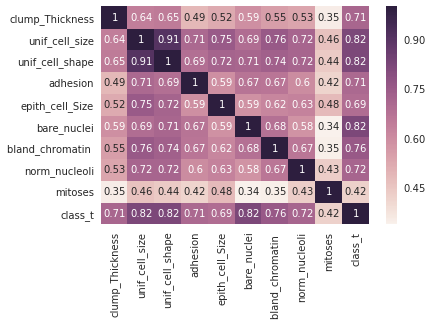

In [18]:
sns.heatmap(df.corr(),annot=True)

¿Qué variables están más correlacionadas entre sí y con la variable dependiente?

## 3. Fiteando un modelo de regresión logística

Dividimos el target y $X$

In [19]:
df.columns

Index(['clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion',
       'epith_cell_Size', 'bare_nuclei', 'bland_chromatin ', 'norm_nucleoli',
       'mitoses', 'class_t'],
      dtype='object')

In [20]:
X = df[['clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion',
       'epith_cell_Size', 'bare_nuclei', 'bland_chromatin ', 'norm_nucleoli',
       'mitoses']]
y = df['class_t']

### 3.1 Usando `scikit-learn`

Vamos a evaluar un modelo usando validación cruzada. La idea es estimar el test error usando validación cruzada en lugar de la partición clásica entre test y train.

La idea es poder guardar mucha información de los modelos estimados.

1. las predicicones de las k iteraciones que realicen
2. los coeficientes de los k modelos estimados
3. los scores de los k modelos estimados
4. las matrices de confusión de los k modelos estimados

**Hint:** traten de usar el iterador [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) del módulo `sklearn.model_selection`.

- Lo que devuelve el método `KFold` es un array de índices con las $k$ particiones entre train y test.

- Luego, pueden usar esos índices para hacer subsetting del dataframe

In [73]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

kf = KFold(n_splits=10)
kf.get_n_splits(X)

C=1e10

split_info = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
 
    predictions = model.predict(X_test)
    coeficients = model.coef_
    score = model.score(X_test, y_test)
    cf_matrix = confusion_matrix(y_test, predictions)

    current_split_info = {
        # 'predictions': predictions,
        'clump_Thickness': coeficients[0][0],
        'unif_cell_size': coeficients[0][1],
        'unif_cell_shape': coeficients[0][2],
        'adhesion': coeficients[0][3],
        'epith_cell_Size': coeficients[0][4],
        'bare_nuclei': coeficients[0][5],
        'bland_chromatin': coeficients[0][6],
        'norm_nucleoli': coeficients[0][7],
        'mitoses': coeficients[0][8],
        'score': score
        #'cf_matrix': cf_matrix
    }
    
    split_info.append(current_split_info)
    
results = pd.DataFrame(split_info)
results.sort_values('score', ascending=False)

,adhesion,bare_nuclei,bland_chromatin,clump_Thickness,epith_cell_Size,mitoses,norm_nucleoli,score,unif_cell_shape,unif_cell_size
5,0.327143,0.373089,0.431825,0.515400,0.087032,0.522212,0.210371,1.000000,0.315679,0.002296
8,0.328669,0.370425,0.444116,0.546717,0.094016,0.506551,0.205072,1.000000,0.317423,-0.032023
9,0.316952,0.376895,0.404553,0.523425,0.125563,0.524805,0.201938,1.000000,0.348482,-0.042026
1,0.314250,0.352945,0.492618,0.575578,0.098414,0.473257,0.190981,0.985507,0.234983,0.052620
7,0.412672,0.390885,0.418779,0.561333,0.100570,0.529389,0.203029,0.985294,0.301793,-0.051007
2,0.417739,0.361120,0.614606,0.655643,0.037624,0.728801,0.356061,0.971014,0.236776,-0.077339
6,0.322056,0.385247,0.418613,0.478106,0.105686,0.509862,0.187042,0.970588,0.404113,0.039610
4,0.278924,0.391723,0.545130,0.513876,0.139565,0.395926,0.223788,0.941176,0.387514,-0.100560
3,0.343432,0.390713,0.389840,0.571235,0.109268,0.734551,0.245618,0.926471,0.414698,0.020843
0,0.278483,0.466452,0.358216,0.455988,0.055927,0.496904,0.148011,0.898551,0.285733,0.127412


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


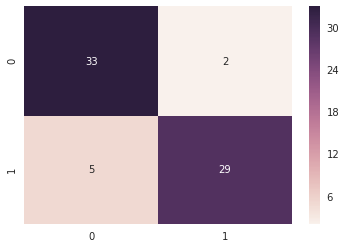

In [67]:
sns.heatmap(results.loc[0,'cf_matrix'], annot=True)

* ¿Cuál es la performance de este modelo?

In [68]:
# ? ask tincho
results[['score']].describe()

,score
count,10.000000
mean,0.967860
std,0.034898
min,0.898551
25%,0.948529
50%,0.978154
75%,0.996377
max,1.000000


### 3.2 Usando  `statsmodels`

Hagamos, ahora, la partición tradicional entre train y test. Primero, agregamos el intercepto (porque `statsmodels` no lo agrega por default).

Estimemos una regresión logística usando `statsmodels`.

Obtengamos la matriz de clasificación en el test set.

¿Cómo funciona el modelo en el test set?

### 3.2 Usando (de nuevo) `sklearn`

Repliquemos, ahora el ejercicio con `sklearn`. 

** ADVERTENCIA **

Recuerden dropear la primera columna de `X_train` y `X_test` (porque agregamos un intercepto). Y, además, dado que `LogisticRegression` aplica un parámetro de regularización por defecto es importante setear el parámetro de la siguiente forma `C=1e10` (es decir, en valores altos).

## 4. Análisis e interpretación

* ¿Qué pueden decir de este modelo?
* ¿Cómo funciona el ajuste del mismo?
* ¿Cuáles son las principales variables predictoras del tipo de tumor?

## 5. Comparación con KNN

Con el mismo split entre train y test que generaron anteriormente, utilizar el conjunto de train para estimar un modelo de KNN con hiperparámetros óptimos y comparar la performance sobre datos no observados con respecto a la regresión logística. 